**TRANSFER LEARNING**

In [17]:
import os
import random
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import torchvision
from torchvision import transforms, datasets, models
from sklearn.model_selection import train_test_split

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
batch_size = 32

transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

base_path = r'C:\Users\dorot\OneDrive - Politecnico di Torino\Desktop\Magistrale\Secondo Anno Magistrale\Machine Learning for Visual and Multimedia\Labs\LAB3\archive'

training_path = os.path.join(base_path, 'training_set', 'training_set')
test_path = os.path.join(base_path, 'test_set', 'test_set')

if not os.path.exists(training_path):
    training_path = os.path.join(base_path, 'training_set')
    test_path = os.path.join(base_path, 'test_set')

print(f"Using training path: {training_path}")
print(f"Using test path: {test_path}")

train_dataset = datasets.ImageFolder(root=training_path, transform=transform_train)
test_set = datasets.ImageFolder(root=test_path, transform=transform_val)

print(f"Train dataset classes: {train_dataset.classes}")
print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_set)}")

train_indexes, val_indexes = train_test_split(range(len(train_dataset)), test_size=0.2, random_state=42, stratify=train_dataset.targets)

train_dataset_no_aug = datasets.ImageFolder(root=training_path, transform=transform_val)

train_set = Subset(train_dataset, train_indexes)  
val_set = Subset(train_dataset_no_aug, val_indexes)  

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=4)

print(f"Train set size: {len(train_set)}")
print(f"Val set size: {len(val_set)}")
print("Setup completed successfully!")

Using training path: C:\Users\dorot\OneDrive - Politecnico di Torino\Desktop\Magistrale\Secondo Anno Magistrale\Machine Learning for Visual and Multimedia\Labs\LAB3\archive\training_set\training_set
Using test path: C:\Users\dorot\OneDrive - Politecnico di Torino\Desktop\Magistrale\Secondo Anno Magistrale\Machine Learning for Visual and Multimedia\Labs\LAB3\archive\test_set\test_set
Train dataset classes: ['cats', 'dogs']
Train dataset size: 8005
Test dataset size: 2023
Train set size: 6404
Val set size: 1601
Setup completed successfully!


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].


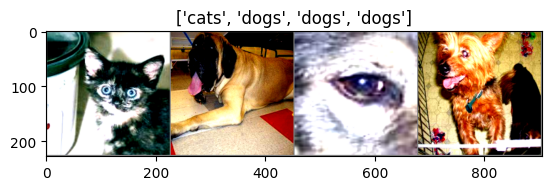

In [21]:
#Print some images from the training set
def imshow(img, title):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()

dataiter = iter(train_loader)
# use the built-in next() for Python iterator objects
images, labels = next(dataiter)
# convert label tensors to Python ints for indexing class names
titles = [train_dataset.classes[int(labels[j])] for j in range(4)]
imshow(torchvision.utils.make_grid(images[:4]), title=titles)


First, let's load the pre-trained model. In the first phase we will train only the final layer and freeze the rest of the layers.

In [22]:
# Load pre-trained model and modify final layer
model_pt = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

in_features = model_pt.fc.in_features
model_pt.fc = nn.Linear(in_features, len(train_dataset.classes))


In [23]:
#Freeze all layers except the final layer
for param in model_pt.parameters():
    param.requires_grad = False

for param in model_pt.fc.parameters():
    param.requires_grad = True

model_pt = model_pt.to(device)

In [24]:
optimizer = optim.SGD(model_pt.fc.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [25]:
warmup_epochs = 5
lr_head = 0.001
weight_decay = 1e-4
save_path = 'resnet18_finetuned_warmup.pth'

In [26]:
def train(model, train_loader, val_loader, criterion, optimizer, epochs, device):
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    model.to(device)

    for epoch in range(1, epochs + 1):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)                 # logits
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        epoch_train_loss = running_loss / total
        epoch_train_acc = correct / total
        train_losses.append(epoch_train_loss)
        train_accs.append(epoch_train_acc)

        # validation
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item() * images.size(0)
                preds = outputs.argmax(dim=1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        epoch_val_loss = val_running_loss / val_total if val_total > 0 else 0.0
        epoch_val_acc = val_correct / val_total if val_total > 0 else 0.0
        val_losses.append(epoch_val_loss)
        val_accs.append(epoch_val_acc)

        print(f"Epoch {epoch}/{epochs}  "
              f"Train loss: {epoch_train_loss:.4f}, Train acc: {epoch_train_acc:.4f}  |  "
              f"Val loss: {epoch_val_loss:.4f}, Val acc: {epoch_val_acc:.4f}")

    return train_losses, val_losses, train_accs, val_accs

Epoch 1/5  Train loss: 0.2528, Train acc: 0.8855  |  Val loss: 0.0831, Val acc: 0.9681
Epoch 2/5  Train loss: 0.1717, Train acc: 0.9268  |  Val loss: 0.0729, Val acc: 0.9700
Epoch 3/5  Train loss: 0.1750, Train acc: 0.9236  |  Val loss: 0.0719, Val acc: 0.9744
Epoch 4/5  Train loss: 0.1539, Train acc: 0.9333  |  Val loss: 0.0633, Val acc: 0.9750
Epoch 5/5  Train loss: 0.1508, Train acc: 0.9354  |  Val loss: 0.0632, Val acc: 0.9725


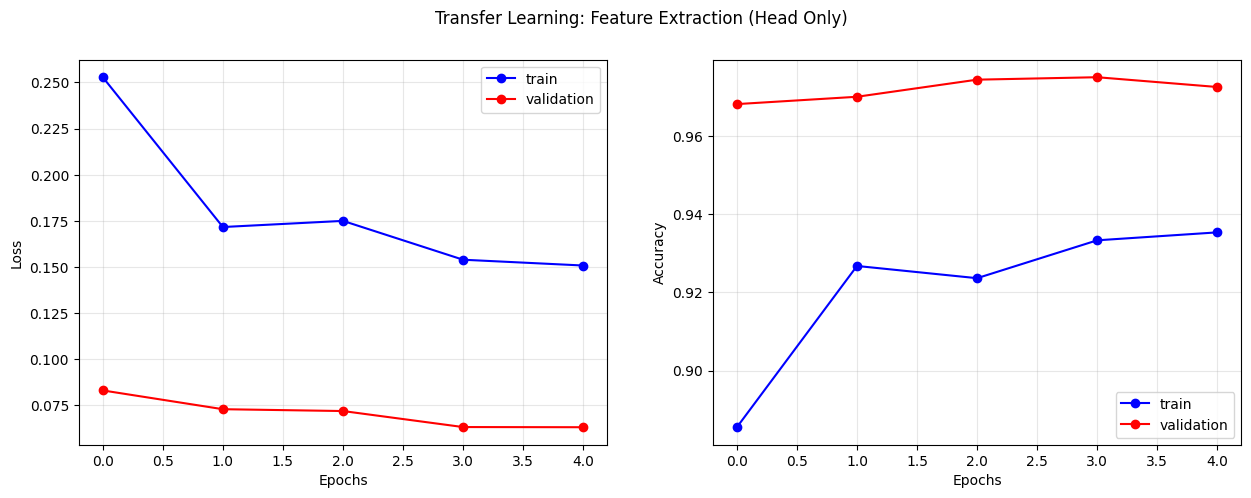

Final training accuracy: 0.9354
Final validation accuracy: 0.9725
Model saved to: resnet18_finetuned_warmup.pth


In [27]:
train_losses1, val_losses1, train_accs1, val_accs1 = train(model_pt, train_loader, val_loader, criterion, optimizer, warmup_epochs, device)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(train_losses1, c='blue', label='train', marker='o')
ax[0].plot(val_losses1, c='red', label='validation', marker='o')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[0].grid(alpha=0.3)

ax[1].plot(train_accs1, c='blue', label='train', marker='o')
ax[1].plot(val_accs1, c='red', label='validation', marker='o')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
ax[1].grid(alpha=0.3)

plt.suptitle("Transfer Learning: Feature Extraction (Head Only)")
plt.show()

print(f"Final training accuracy: {train_accs1[-1]:.4f}")
print(f"Final validation accuracy: {val_accs1[-1]:.4f}")
torch.save(model_pt.state_dict(), save_path)
print(f"Model saved to: {save_path}")

In [29]:
losses = 0
samples = 0
corrects = 0

model_pt.load_state_dict(torch.load('resnet18_finetuned_warmup.pth'))

model_pt.to(device)
model_pt.eval()
with torch.no_grad():
  for batch in test_loader:
    images, labels = batch
    images, labels = images.to(device), labels.to(device)

    samples += batch[0].shape[0]
    preds = model_pt(images)  

    _, label_pred = torch.max(preds.data, 1)
    corrects += torch.sum(labels == label_pred).item()
acc = 100 * 1.0 * corrects / float(samples)
print(f'Accuracy on test set 2: {acc}')

Accuracy on test set 2: 98.36875926841324


1. What is the accuracy when using the pre-trained network as feature extraction (all base layers 
frozen) and training only the added top layer (warm up)? 98.37%

Now, let's unfreeze the backbone and the fc layer added, and let's train the model to observe how the accuracy will change.

In [30]:
for param in model_pt.parameters():
    param.requires_grad = True

for param in model_pt.fc.parameters():
    param.requires_grad = True

In [31]:
backbone_params = []
head_params = []


for name, param in model_pt.named_parameters():
    if 'fc' in name:
        head_params.append(param)
    else:
        backbone_params.append(param)

print(f"Number of backbone parameters: {len(backbone_params)}")
print(f"Number of head parameters: {len(head_params)}")

Number of backbone parameters: 60
Number of head parameters: 2


In [32]:
lr_backbone = 0.0001
lr_head = 0.001
save_path = 'resnet18_finetuned.pth'

optimizer = optim.SGD([
    {'params': backbone_params, 'lr': lr_backbone},
    {'params': head_params, 'lr': lr_head},
], momentum=0.9, weight_decay=weight_decay)

criterion = nn.CrossEntropyLoss()

Epoch 1/5  Train loss: 0.1295, Train acc: 0.9438  |  Val loss: 0.0514, Val acc: 0.9781
Epoch 2/5  Train loss: 0.1236, Train acc: 0.9464  |  Val loss: 0.0468, Val acc: 0.9838
Epoch 3/5  Train loss: 0.1268, Train acc: 0.9458  |  Val loss: 0.0469, Val acc: 0.9806
Epoch 4/5  Train loss: 0.1132, Train acc: 0.9517  |  Val loss: 0.0493, Val acc: 0.9794
Epoch 5/5  Train loss: 0.1111, Train acc: 0.9513  |  Val loss: 0.0431, Val acc: 0.9825


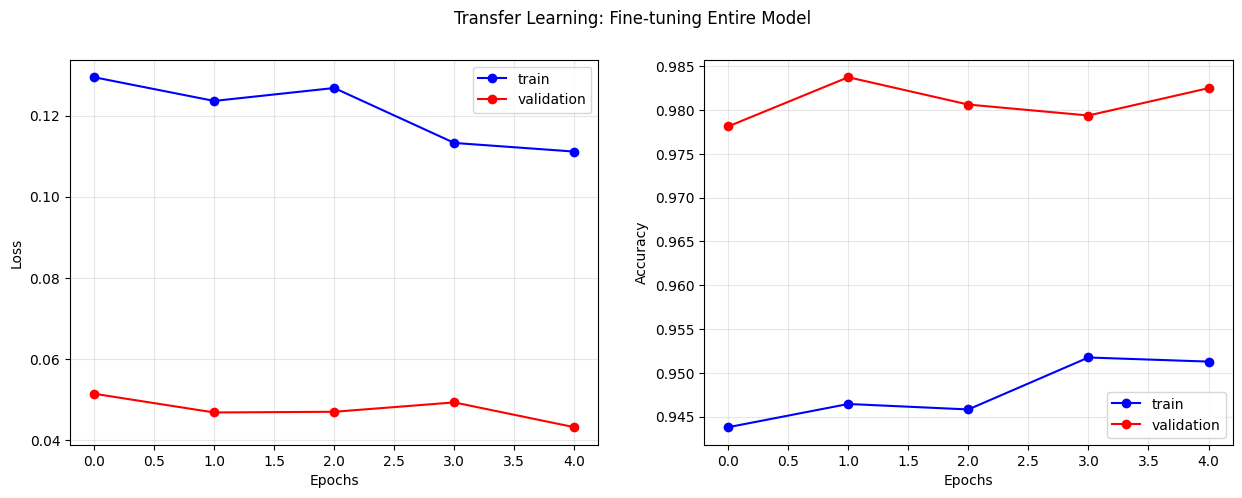

Final training accuracy: 0.9513
Final validation accuracy: 0.9825
Model saved to: resnet18_finetuned.pth


In [34]:
finetune_epochs = 5
train_losses2, val_losses2, train_accs2, val_accs2 = train(model_pt, train_loader, val_loader, criterion, optimizer, finetune_epochs, device)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(train_losses2, c='blue', label='train', marker='o')
ax[0].plot(val_losses2, c='red', label='validation', marker='o')
ax[0].set_xlabel('Epochs') 
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[0].grid(alpha=0.3)
ax[1].plot(train_accs2, c='blue', label='train', marker='o')
ax[1].plot(val_accs2, c='red', label='validation', marker='o')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
ax[1].grid(alpha=0.3)
plt.suptitle("Transfer Learning: Fine-tuning Entire Model")
plt.show()

print(f"Final training accuracy: {train_accs2[-1]:.4f}")
print(f"Final validation accuracy: {val_accs2[-1]:.4f}")
torch.save(model_pt.state_dict(), save_path)
print(f"Model saved to: {save_path}")

In [35]:
losses = 0
samples = 0
corrects = 0

model_pt.load_state_dict(torch.load('resnet18_finetuned.pth'))

model_pt.to(device)
model_pt.eval()
with torch.no_grad():
  for batch in test_loader:
    images, labels = batch
    images, labels = images.to(device), labels.to(device)

    samples += batch[0].shape[0]
    preds = model_pt(images)  

    _, label_pred = torch.max(preds.data, 1)
    corrects += torch.sum(labels == label_pred).item()
acc = 100 * 1.0 * corrects / float(samples)
print(f'Accuracy on test set 2: {acc}')

Accuracy on test set 2: 98.56648541769648


2. What is the accuracy after fine-tuning the transferred  layers? 98.56%

Now, let's unfreeze just few layers of the backbone model

Experiment 1 -> Layer 4 + fc

In [36]:
# Load pre-trained model and modify final layer
model_pt = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

in_features = model_pt.fc.in_features
model_pt.fc = nn.Linear(in_features, len(train_dataset.classes))
model_pt = model_pt.to(device)

In [37]:
for param in model_pt.parameters():
    param.requires_grad = False

for param in model_pt.fc.parameters():
    param.requires_grad = True

In [38]:
for name, param in model_pt.named_parameters():
    if name.startswith('layer4') or name.startswith('fc'):
        param.requires_grad = True


In [39]:
trainable_params = 0
for name, param in model_pt.named_parameters():
    if param.requires_grad:
        print(f"  {name}: {param.shape}")
        trainable_params += param.numel()
print(f"Trainable parameters: {trainable_params:,}")


  layer4.0.conv1.weight: torch.Size([512, 256, 3, 3])
  layer4.0.bn1.weight: torch.Size([512])
  layer4.0.bn1.bias: torch.Size([512])
  layer4.0.conv2.weight: torch.Size([512, 512, 3, 3])
  layer4.0.bn2.weight: torch.Size([512])
  layer4.0.bn2.bias: torch.Size([512])
  layer4.0.downsample.0.weight: torch.Size([512, 256, 1, 1])
  layer4.0.downsample.1.weight: torch.Size([512])
  layer4.0.downsample.1.bias: torch.Size([512])
  layer4.1.conv1.weight: torch.Size([512, 512, 3, 3])
  layer4.1.bn1.weight: torch.Size([512])
  layer4.1.bn1.bias: torch.Size([512])
  layer4.1.conv2.weight: torch.Size([512, 512, 3, 3])
  layer4.1.bn2.weight: torch.Size([512])
  layer4.1.bn2.bias: torch.Size([512])
  fc.weight: torch.Size([2, 512])
  fc.bias: torch.Size([2])
Trainable parameters: 8,394,754


In [40]:
partial_backbone_params = []
head_params = []

for name, param in model_pt.named_parameters():
    if param.requires_grad:
        if 'fc' in name:
            head_params.append(param)
        else:
            partial_backbone_params.append(param)
print(f"Number of partially unfrozen backbone parameters: {len(partial_backbone_params)}")
print(f"Number of head parameters: {len(head_params)}")

Number of partially unfrozen backbone parameters: 15
Number of head parameters: 2


In [41]:
lr_partial_backbone = 1e-4
lr_head = 1e-3

optimizer_partial = optim.SGD([
    {'params': partial_backbone_params, 'lr': lr_partial_backbone},
    {'params': head_params, 'lr': lr_head}
], momentum=0.9, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

Epoch 1/5  Train loss: 0.2321, Train acc: 0.9047  |  Val loss: 0.0749, Val acc: 0.9694
Epoch 2/5  Train loss: 0.1683, Train acc: 0.9271  |  Val loss: 0.0629, Val acc: 0.9806
Epoch 3/5  Train loss: 0.1517, Train acc: 0.9364  |  Val loss: 0.0585, Val acc: 0.9763
Epoch 4/5  Train loss: 0.1470, Train acc: 0.9352  |  Val loss: 0.0600, Val acc: 0.9775
Epoch 5/5  Train loss: 0.1284, Train acc: 0.9436  |  Val loss: 0.0541, Val acc: 0.9769


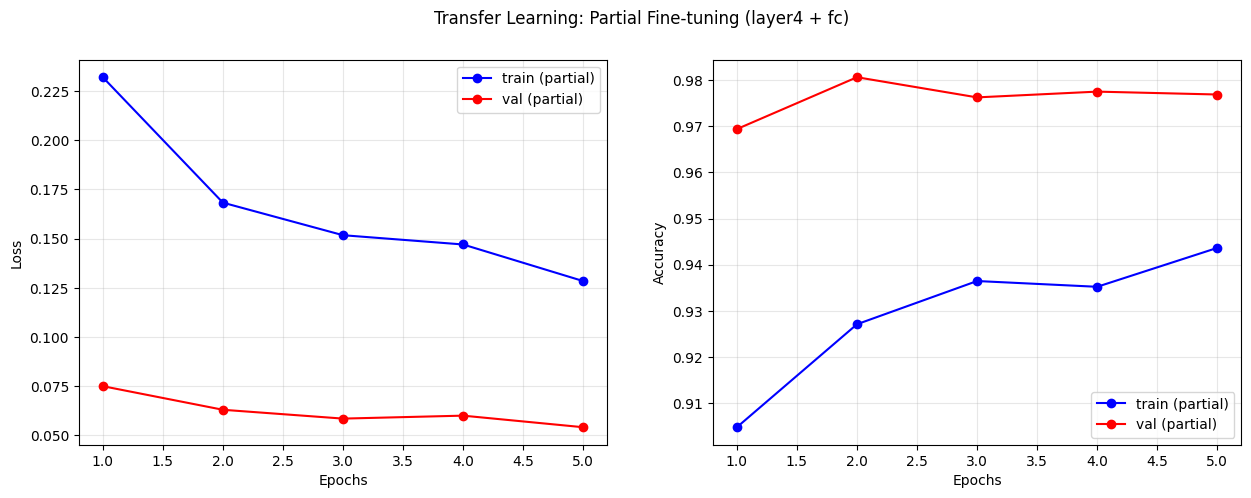

In [43]:
partial_epochs = 5

train_losses3, val_losses3, train_accs3, val_accs3 = train(
    model_pt, train_loader, val_loader, criterion, optimizer_partial, partial_epochs, device
)


fig, ax = plt.subplots(1, 2, figsize=(15, 5))
epochs3 = range(1, len(train_accs3) + 1)

ax[0].plot(epochs3, train_losses3, c='blue', label='train (partial)', marker='o')
ax[0].plot(epochs3, val_losses3, c='red', label='val (partial)', marker='o')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[0].grid(alpha=0.3)

ax[1].plot(epochs3, train_accs3, c='blue', label='train (partial)', marker='o')
ax[1].plot(epochs3, val_accs3, c='red', label='val (partial)', marker='o')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
ax[1].grid(alpha=0.3)

plt.suptitle("Transfer Learning: Partial Fine-tuning (layer4 + fc)")
plt.show()

torch.save(model_pt.state_dict(), 'resnet18_partial_finetune.pth')

In [45]:
losses = 0
samples = 0
corrects = 0

model_pt.load_state_dict(torch.load('resnet18_partial_finetune.pth'))

model_pt.to(device)
model_pt.eval()
with torch.no_grad():
  for batch in test_loader:
    images, labels = batch
    images, labels = images.to(device), labels.to(device)

    samples += batch[0].shape[0]
    preds = model_pt(images)  

    _, label_pred = torch.max(preds.data, 1)
    corrects += torch.sum(labels == label_pred).item()
acc = 100 * 1.0 * corrects / float(samples)
print(f'Accuracy on test set 2: {acc}')

Accuracy on test set 2: 98.31932773109244


Experiment 2 -> Layer 3 + Layer 4 + fc

In [46]:
# Load pre-trained model and modify final layer
model_pt = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

in_features = model_pt.fc.in_features
model_pt.fc = nn.Linear(in_features, len(train_dataset.classes))
model_pt = model_pt.to(device)


for name, param in model_pt.named_parameters():
    if name.startswith('layer3') or name.startswith('layer4') or name.startswith('fc'):
        param.requires_grad = True


partial_backbone_params = []
head_params = []

for name, param in model_pt.named_parameters():
    if param.requires_grad:
        if 'fc' in name:
            head_params.append(param)
        else:
            partial_backbone_params.append(param)
print(f"Number of partially unfrozen backbone parameters: {len(partial_backbone_params)}")
print(f"Number of head parameters: {len(head_params)}")

lr_partial_backbone = 1e-4
lr_head = 1e-3

optimizer_partial = optim.SGD([
    {'params': partial_backbone_params, 'lr': lr_partial_backbone},
    {'params': head_params, 'lr': lr_head}
], momentum=0.9, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

Number of partially unfrozen backbone parameters: 60
Number of head parameters: 2


Epoch 1/5  Train loss: 0.2429, Train acc: 0.8968  |  Val loss: 0.0750, Val acc: 0.9706
Epoch 2/5  Train loss: 0.1536, Train acc: 0.9357  |  Val loss: 0.0605, Val acc: 0.9738
Epoch 3/5  Train loss: 0.1442, Train acc: 0.9355  |  Val loss: 0.0531, Val acc: 0.9794
Epoch 4/5  Train loss: 0.1332, Train acc: 0.9410  |  Val loss: 0.0487, Val acc: 0.9788
Epoch 5/5  Train loss: 0.1292, Train acc: 0.9461  |  Val loss: 0.0476, Val acc: 0.9813


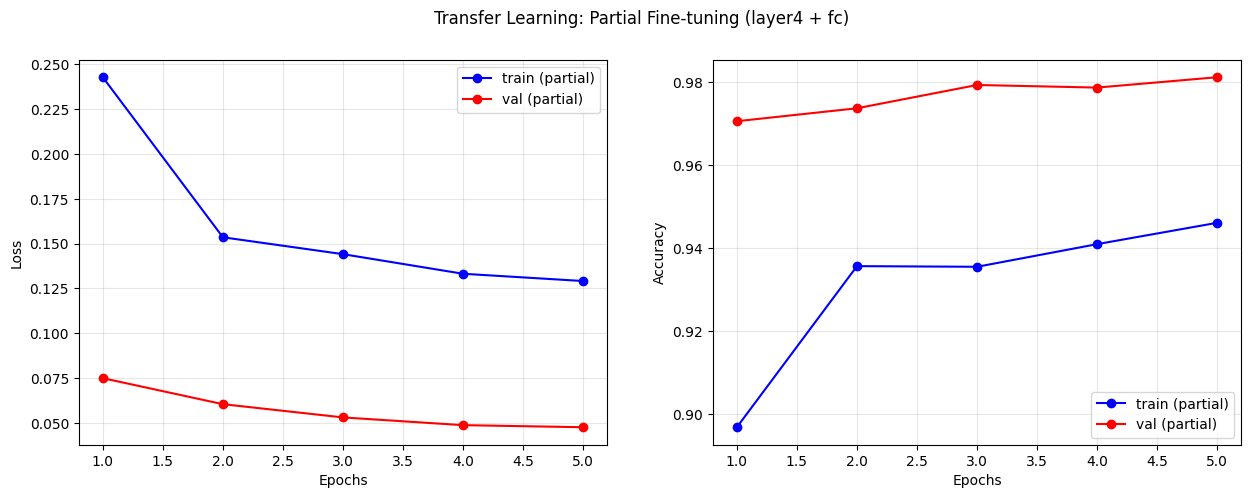

In [47]:
partial_epochs = 5

train_losses3, val_losses3, train_accs3, val_accs3 = train(
    model_pt, train_loader, val_loader, criterion, optimizer_partial, partial_epochs, device
)


fig, ax = plt.subplots(1, 2, figsize=(15, 5))
epochs3 = range(1, len(train_accs3) + 1)

ax[0].plot(epochs3, train_losses3, c='blue', label='train (partial)', marker='o')
ax[0].plot(epochs3, val_losses3, c='red', label='val (partial)', marker='o')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[0].grid(alpha=0.3)

ax[1].plot(epochs3, train_accs3, c='blue', label='train (partial)', marker='o')
ax[1].plot(epochs3, val_accs3, c='red', label='val (partial)', marker='o')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
ax[1].grid(alpha=0.3)

plt.suptitle("Transfer Learning: Partial Fine-tuning (layer4 + fc)")
plt.show()

torch.save(model_pt.state_dict(), 'resnet18_partial_finetune2.pth')

In [48]:
losses = 0
samples = 0
corrects = 0

model_pt.load_state_dict(torch.load('resnet18_partial_finetune2.pth'))

model_pt.to(device)
model_pt.eval()
with torch.no_grad():
  for batch in test_loader:
    images, labels = batch
    images, labels = images.to(device), labels.to(device)

    samples += batch[0].shape[0]
    preds = model_pt(images)  

    _, label_pred = torch.max(preds.data, 1)
    corrects += torch.sum(labels == label_pred).item()
acc = 100 * 1.0 * corrects / float(samples)
print(f'Accuracy on test set 2: {acc}')

Accuracy on test set 2: 98.31932773109244


3. How does the accuracy change if we fine-tune only part of the layers? It is worst then the first two cases, only 98.3%

Now, let's reload the model without the warmup phase, and let's analyze how the accuracy will change

In [49]:
# Load pre-trained model and modify final layer
model_pt = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

in_features = model_pt.fc.in_features
model_pt.fc = nn.Linear(in_features, len(train_dataset.classes))

model_pt = model_pt.to(device)

In [50]:
for param in model_pt.parameters():
    param.requires_grad = True

for param in model_pt.fc.parameters():
    param.requires_grad = True

In [51]:
backbone_params = []
head_params = []


for name, param in model_pt.named_parameters():
    if 'fc' in name:
        head_params.append(param)
    else:
        backbone_params.append(param)

print(f"Number of backbone parameters: {len(backbone_params)}")
print(f"Number of head parameters: {len(head_params)}")

Number of backbone parameters: 60
Number of head parameters: 2


In [52]:
lr_backbone = 0.0001
lr_head = 0.001
save_path = 'resnet18_finetuned_nowarmup.pth'

optimizer = optim.SGD([
    {'params': backbone_params, 'lr': lr_backbone},
    {'params': head_params, 'lr': lr_head},
], momentum=0.9, weight_decay=weight_decay)

criterion = nn.CrossEntropyLoss()

Epoch 1/5  Train loss: 0.2503, Train acc: 0.8815  |  Val loss: 0.0706, Val acc: 0.9681
Epoch 2/5  Train loss: 0.1597, Train acc: 0.9324  |  Val loss: 0.0606, Val acc: 0.9719
Epoch 3/5  Train loss: 0.1451, Train acc: 0.9388  |  Val loss: 0.0642, Val acc: 0.9725
Epoch 4/5  Train loss: 0.1405, Train acc: 0.9383  |  Val loss: 0.0491, Val acc: 0.9831
Epoch 5/5  Train loss: 0.1472, Train acc: 0.9357  |  Val loss: 0.0502, Val acc: 0.9813


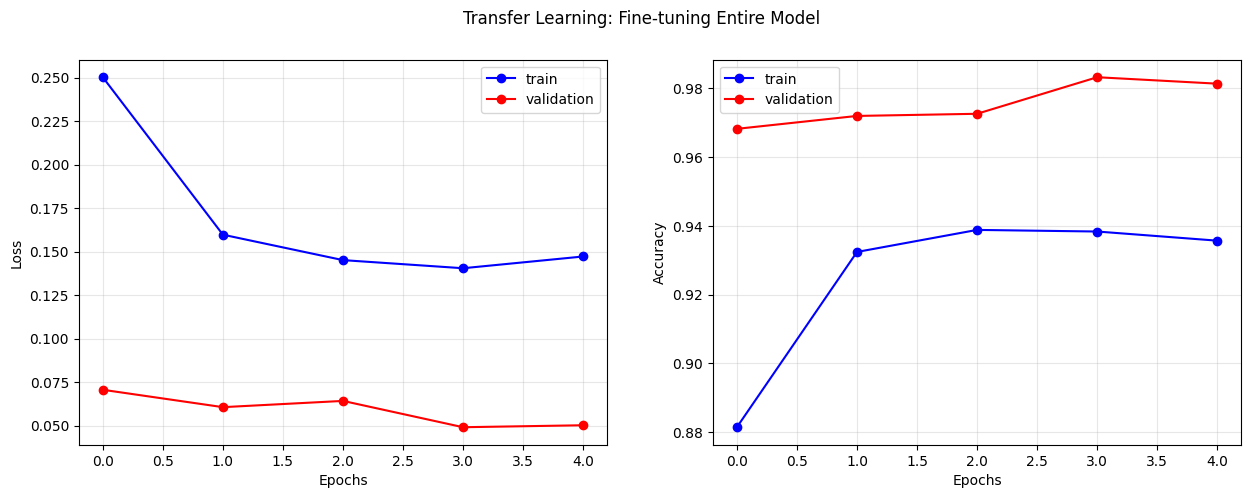

Final training accuracy: 0.9357
Final validation accuracy: 0.9813
Model saved to: resnet18_finetuned_nowarmup.pth


In [53]:
finetune_epochs = 5
train_losses3, val_losses3, train_accs3, val_accs3 = train(model_pt, train_loader, val_loader, criterion, optimizer, finetune_epochs, device)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(train_losses3, c='blue', label='train', marker='o')
ax[0].plot(val_losses3, c='red', label='validation', marker='o')
ax[0].set_xlabel('Epochs') 
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[0].grid(alpha=0.3)
ax[1].plot(train_accs3, c='blue', label='train', marker='o')
ax[1].plot(val_accs3, c='red', label='validation', marker='o')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
ax[1].grid(alpha=0.3)
plt.suptitle("Transfer Learning: Fine-tuning Entire Model")
plt.show()

print(f"Final training accuracy: {train_accs3[-1]:.4f}")
print(f"Final validation accuracy: {val_accs3[-1]:.4f}")
torch.save(model_pt.state_dict(), save_path)
print(f"Model saved to: {save_path}")

In [54]:
losses = 0
samples = 0
corrects = 0

model_pt.load_state_dict(torch.load(save_path))

model_pt.to(device)
model_pt.eval()
with torch.no_grad():
  for batch in test_loader:
    images, labels = batch
    images, labels = images.to(device), labels.to(device)

    samples += batch[0].shape[0]
    preds = model_pt(images)  

    _, label_pred = torch.max(preds.data, 1)
    corrects += torch.sum(labels == label_pred).item()
acc = 100 * 1.0 * corrects / float(samples)
print(f'Accuracy on test set 3: {acc}')

Accuracy on test set 3: 98.07217004448839


4. How does the performance change with and without a warm up stage? The accuracy is lower, only 98.07%

In [55]:
batch_size = 32

transform_train = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

base_path = r'C:\Users\dorot\OneDrive - Politecnico di Torino\Desktop\Magistrale\Secondo Anno Magistrale\Machine Learning for Visual and Multimedia\Labs\LAB3\archive'

training_path = os.path.join(base_path, 'training_set', 'training_set')
test_path = os.path.join(base_path, 'test_set', 'test_set')

if not os.path.exists(training_path):
    training_path = os.path.join(base_path, 'training_set')
    test_path = os.path.join(base_path, 'test_set')

print(f"Using training path: {training_path}")
print(f"Using test path: {test_path}")

train_dataset = datasets.ImageFolder(root=training_path, transform=transform_train)
test_set = datasets.ImageFolder(root=test_path, transform=transform_val)

print(f"Train dataset classes: {train_dataset.classes}")
print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_set)}")

train_indexes, val_indexes = train_test_split(range(len(train_dataset)), test_size=0.2, random_state=42, stratify=train_dataset.targets)

train_dataset_no_aug = datasets.ImageFolder(root=training_path, transform=transform_val)

train_set = Subset(train_dataset, train_indexes)  
val_set = Subset(train_dataset_no_aug, val_indexes)  

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=4)

print(f"Train set size: {len(train_set)}")
print(f"Val set size: {len(val_set)}")
print("Setup completed successfully!")

Using training path: C:\Users\dorot\OneDrive - Politecnico di Torino\Desktop\Magistrale\Secondo Anno Magistrale\Machine Learning for Visual and Multimedia\Labs\LAB3\archive\training_set\training_set
Using test path: C:\Users\dorot\OneDrive - Politecnico di Torino\Desktop\Magistrale\Secondo Anno Magistrale\Machine Learning for Visual and Multimedia\Labs\LAB3\archive\test_set\test_set
Train dataset classes: ['cats', 'dogs']
Train dataset size: 8005
Test dataset size: 2023
Train set size: 6404
Val set size: 1601
Setup completed successfully!


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].


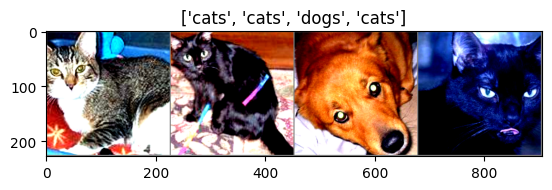

In [56]:
#Print some images from the training set
def imshow(img, title):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()

dataiter = iter(train_loader)
# use the built-in next() for Python iterator objects
images, labels = next(dataiter)
# convert label tensors to Python ints for indexing class names
titles = [train_dataset.classes[int(labels[j])] for j in range(4)]
imshow(torchvision.utils.make_grid(images[:4]), title=titles)


In [57]:
# Load pre-trained model and modify final layer
model_pt = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

in_features = model_pt.fc.in_features
model_pt.fc = nn.Linear(in_features, len(train_dataset.classes))


In [58]:
#Freeze all layers except the final layer
for param in model_pt.parameters():
    param.requires_grad = False

for param in model_pt.fc.parameters():
    param.requires_grad = True

model_pt = model_pt.to(device)

In [59]:
optimizer = optim.SGD(model_pt.fc.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [60]:
warmup_epochs = 5
lr_head = 0.001
weight_decay = 1e-4
save_path = 'resnet18_finetuned_warmup_noaug.pth'

Epoch 1/5  Train loss: 0.1685, Train acc: 0.9371  |  Val loss: 0.0913, Val acc: 0.9650
Epoch 2/5  Train loss: 0.0886, Train acc: 0.9677  |  Val loss: 0.0731, Val acc: 0.9706
Epoch 3/5  Train loss: 0.0896, Train acc: 0.9644  |  Val loss: 0.0700, Val acc: 0.9694
Epoch 4/5  Train loss: 0.0844, Train acc: 0.9666  |  Val loss: 0.0926, Val acc: 0.9650
Epoch 5/5  Train loss: 0.0846, Train acc: 0.9656  |  Val loss: 0.0657, Val acc: 0.9719


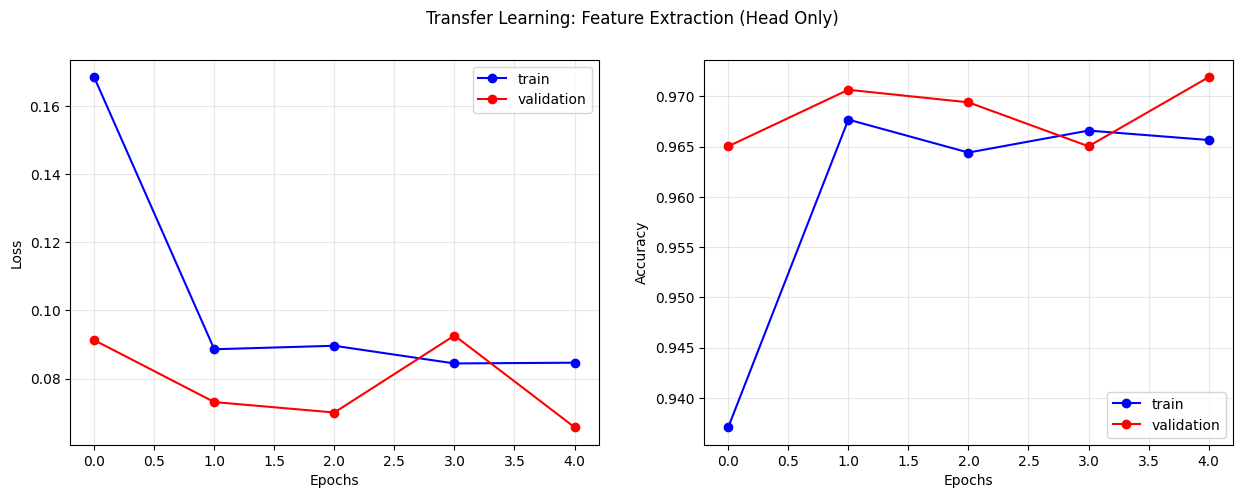

Final training accuracy: 0.9656
Final validation accuracy: 0.9719
Model saved to: resnet18_finetuned_warmup_noaug.pth


In [61]:
train_losses5, val_losses5, train_accs5, val_accs5 = train(model_pt, train_loader, val_loader, criterion, optimizer, warmup_epochs, device)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(train_losses5, c='blue', label='train', marker='o')
ax[0].plot(val_losses5, c='red', label='validation', marker='o')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[0].grid(alpha=0.3)

ax[1].plot(train_accs5, c='blue', label='train', marker='o')
ax[1].plot(val_accs5, c='red', label='validation', marker='o')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
ax[1].grid(alpha=0.3)

plt.suptitle("Transfer Learning: Feature Extraction (Head Only)")
plt.show()

print(f"Final training accuracy: {train_accs5[-1]:.4f}")
print(f"Final validation accuracy: {val_accs5[-1]:.4f}")
torch.save(model_pt.state_dict(), save_path)
print(f"Model saved to: {save_path}")

In [62]:
losses = 0
samples = 0
corrects = 0

model_pt.load_state_dict(torch.load('resnet18_finetuned_warmup.pth'))

model_pt.to(device)
model_pt.eval()
with torch.no_grad():
  for batch in test_loader:
    images, labels = batch
    images, labels = images.to(device), labels.to(device)

    samples += batch[0].shape[0]
    preds = model_pt(images)  

    _, label_pred = torch.max(preds.data, 1)
    corrects += torch.sum(labels == label_pred).item()
acc = 100 * 1.0 * corrects / float(samples)
print(f'Accuracy on test set 5: {acc}')

Accuracy on test set 5: 98.36875926841324


In [63]:
for param in model_pt.parameters():
    param.requires_grad = True

for param in model_pt.fc.parameters():
    param.requires_grad = True

In [64]:
backbone_params = []
head_params = []


for name, param in model_pt.named_parameters():
    if 'fc' in name:
        head_params.append(param)
    else:
        backbone_params.append(param)

print(f"Number of backbone parameters: {len(backbone_params)}")
print(f"Number of head parameters: {len(head_params)}")

Number of backbone parameters: 60
Number of head parameters: 2


In [65]:
lr_backbone = 0.0001
lr_head = 0.001
save_path = 'resnet18_finetuned_noaug.pth'

optimizer = optim.SGD([
    {'params': backbone_params, 'lr': lr_backbone},
    {'params': head_params, 'lr': lr_head},
], momentum=0.9, weight_decay=weight_decay)

criterion = nn.CrossEntropyLoss()

Epoch 1/5  Train loss: 0.0753, Train acc: 0.9708  |  Val loss: 0.0657, Val acc: 0.9725
Epoch 2/5  Train loss: 0.0677, Train acc: 0.9728  |  Val loss: 0.0596, Val acc: 0.9769
Epoch 3/5  Train loss: 0.0578, Train acc: 0.9786  |  Val loss: 0.0537, Val acc: 0.9769
Epoch 4/5  Train loss: 0.0531, Train acc: 0.9809  |  Val loss: 0.0508, Val acc: 0.9781
Epoch 5/5  Train loss: 0.0442, Train acc: 0.9831  |  Val loss: 0.0537, Val acc: 0.9763


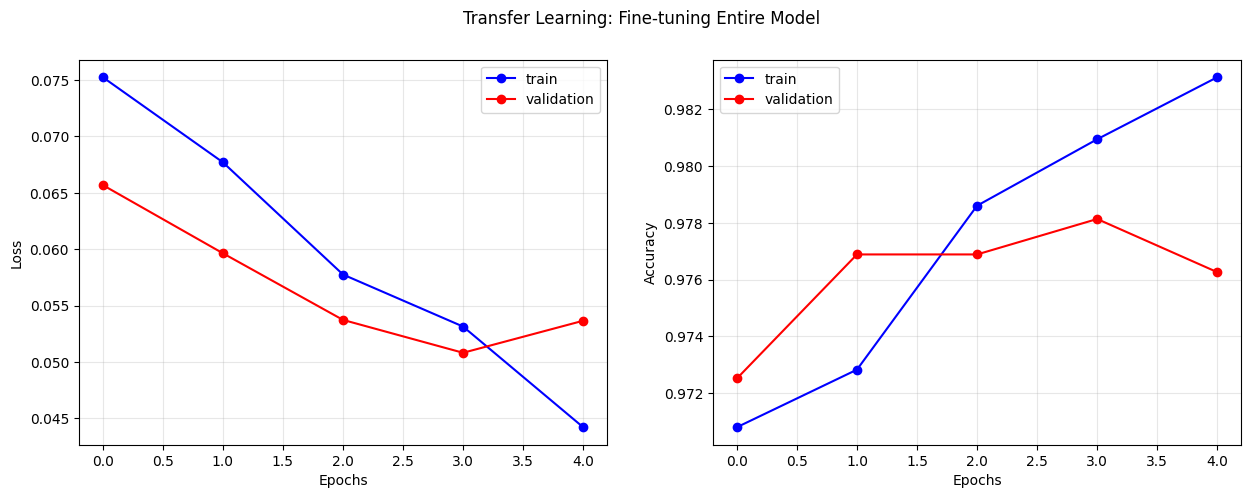

Final training accuracy: 0.9831
Final validation accuracy: 0.9763
Model saved to: resnet18_finetuned_noaug.pth


In [66]:
finetune_epochs = 5
train_losses6, val_losses6, train_accs6, val_accs6 = train(model_pt, train_loader, val_loader, criterion, optimizer, finetune_epochs, device)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(train_losses6, c='blue', label='train', marker='o')
ax[0].plot(val_losses6, c='red', label='validation', marker='o')
ax[0].set_xlabel('Epochs') 
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[0].grid(alpha=0.3)
ax[1].plot(train_accs6, c='blue', label='train', marker='o')
ax[1].plot(val_accs6, c='red', label='validation', marker='o')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
ax[1].grid(alpha=0.3)
plt.suptitle("Transfer Learning: Fine-tuning Entire Model")
plt.show()

print(f"Final training accuracy: {train_accs6[-1]:.4f}")
print(f"Final validation accuracy: {val_accs6[-1]:.4f}")
torch.save(model_pt.state_dict(), save_path)
print(f"Model saved to: {save_path}")

In [67]:
losses = 0
samples = 0
corrects = 0

model_pt.load_state_dict(torch.load(save_path))

model_pt.to(device)
model_pt.eval()
with torch.no_grad():
  for batch in test_loader:
    images, labels = batch
    images, labels = images.to(device), labels.to(device)

    samples += batch[0].shape[0]
    preds = model_pt(images)  

    _, label_pred = torch.max(preds.data, 1)
    corrects += torch.sum(labels == label_pred).item()
acc = 100 * 1.0 * corrects / float(samples)
print(f'Accuracy on test set 6: {acc}')

Accuracy on test set 6: 98.12160158180919


5. How does the validation performance change without data augmentation? It decreases